### Morph a 3D mirror via gradient descent

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib.animation import FuncAnimation

import numpy as np
import seaborn as sns

from LattyMorph.morphing import create_flat_3D_sheet
from LattyMorph.morphing.lattice_models import Toti3D

from tqdm import trange
import torch

Create the initial lattice

<IPython.core.display.Javascript object>


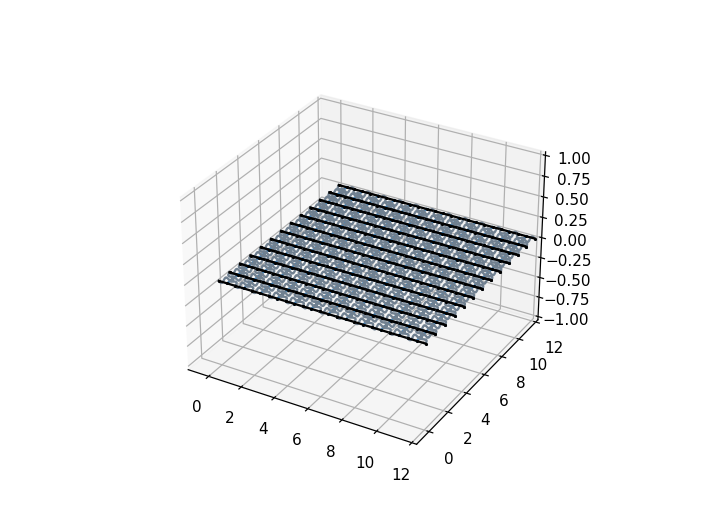

<Axes3D: >

In [2]:
xnum = 12

model = create_flat_3D_sheet(xnum,xnum)

model.plot((-1,12), (-1,12), (-1,1), msize=1)

Morph to a sinusoidal shape

In [3]:
from tqdm import trange

tgt = [0, 0.35, 1.2, 0.35, 0]

def calc_loss(model):
    lossf = torch.nn.MSELoss()
    loss = 0

    for i in range(xnum):
        for j in range(xnum):
            loss += lossf(model.lattice[i][j].pointA[1:], torch.Tensor([i, np.sin(j*2*np.pi/xnum)]))
        loss += lossf(model.lattice[i][-1].pointB[1:], torch.Tensor([i, np.sin(xnum*2*np.pi/xnum)]))
        loss += lossf(model.lattice[-1][i].pointAprime[1:], torch.Tensor([xnum, np.sin(i*2*np.pi/xnum)]))
    loss += lossf(model.lattice[-1][-1].pointBprime[1:], torch.Tensor([xnum, np.sin(xnum*2*np.pi/xnum)]))
        
    return loss

configs = []
configs.append(model.lattice_config())
steps = 700

pbar = trange(steps)
for i in pbar:
    if i%100 == 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    optimizer.zero_grad()
    valid = model.forward()
    if valid == False:
        print("Yikes!")
        break
    loss = calc_loss(model)
    loss.backward()
    optimizer.step()
    pbar.set_description('Loss: {:.5f}'.format(loss.detach()))
    configs.append(model.lattice_config())

Loss: 0.00502: 100%|██████████████████████████████████████████████████████████████████| 700/700 [06:00<00:00,  1.94it/s]


Visualize...

<IPython.core.display.Javascript object>


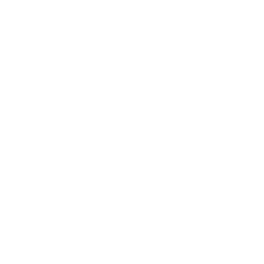

In [4]:
plt.rcParams['figure.dpi'] = 50
plt.rcParams['savefig.bbox'] = 'tight'

fig = plt.figure(figsize=(plt.figaspect(1)))
ax = fig.add_subplot(1, 1, 1, projection='3d')
sns.despine(ax=ax, bottom=True,top=True,left=True,right=True)
ln, = ax.plot3D([0], [0], [0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax._axis3don = False

def init():
    return ln,

def update(kk):
    ax.clear()
    ax.view_init(elev=30, azim = 90+kk*360/(700*2), roll = 0)
    with torch.no_grad():
        model_plt = Toti3D(configs[kk][0], origin = configs[kk][1]['origin'])
        model_plt.forward()
        model_plt.plot(ax=ax, xlim=(-0.,xnum), ylim=(-0.,xnum), zlim = (-0.5,1.5), msize=1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
    ax._axis3don = False
    plt.tight_layout()

ani = FuncAnimation(fig, update, frames=np.arange(0,700,25),
                    init_func=init, blit=True)

# ani.save('Totimorphing_Analytical3DsinRotating.gif')

Continue morphing into a parabolic shape

In [5]:
tgt = [0, 0.35, 1.2, 0.35, 0]

def calc_loss(model):
    lossf = torch.nn.MSELoss()
    loss = 0

    for i in range(xnum):
        for j in range(xnum):
            loss += lossf(model.lattice[i][j].pointA[1:], torch.Tensor([i, ((i-6)**2/6**2/2+0.75*(j-6)**2/6**2/2-0.5-0.75*0.5)*0.5]))
        loss += lossf(model.lattice[i][-1].pointB[1:], torch.Tensor([i, 0]))
        loss += lossf(model.lattice[-1][i].pointAprime[1:], torch.Tensor([xnum, ((i-6)**2/6**2/2+0.75*(12-6)**2/6**2/2-0.5-0.75*0.5)*0.5]))
    loss += lossf(model.lattice[-1][-1].pointBprime[1:], torch.Tensor([xnum, 0]))

    return loss

configs = []
origins = []
conf, orig = model.lattice_config()
configs.append(conf)
origins.append(orig['origin'].numpy().tolist())
steps = 900

pbar = trange(steps)
for i in pbar:
    if i%100 == 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    optimizer.zero_grad()
    valid = model.forward()
    if valid == False:
        print("Yikes!")
        break
    loss = calc_loss(model)
    loss.backward()
    optimizer.step()
    pbar.set_description('Loss: {:.5f}'.format(loss.detach()))
    conf, orig = model.lattice_config()
    configs.append(conf)
    origins.append(orig['origin'].numpy().tolist())

Loss: 0.00124: 100%|██████████████████████████████████████████████████████████████████| 900/900 [07:34<00:00,  1.98it/s]


Visualize

<IPython.core.display.Javascript object>


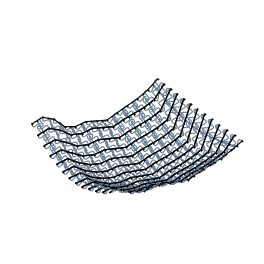

In [6]:
plt.rcParams['figure.dpi'] = 50
plt.rcParams['savefig.bbox'] = 'tight'

fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
sns.despine(ax=ax, bottom=True,top=True,left=True,right=True)
ln, = ax.plot3D([0], [0], [0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax._axis3don = False


def init():
    return ln,

def update(kk):
    ax.clear()
    ax.view_init(elev=30, azim = 90+kk*360/(700*2), roll = 0)
    with torch.no_grad():
        model_plt = Toti3D(configs[kk], torch.Tensor(origins[kk]))
        model_plt.forward()
        model_plt.plot(ax=ax, xlim=(-0.,xnum), ylim=(-0.,xnum), zlim = (-0.5,.5), msize=1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
    ax._axis3don = False
    plt.tight_layout()

ani = FuncAnimation(fig, update, frames=np.arange(0,900,25),
                    init_func=init, blit=True)

# ani.save('Totimorphing_Analytical3DParabolaRotatingFromSine.gif')